In [1]:
import numpy as np 

import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline 

In [2]:
eta = 1e-4; T = 60000; epsilon = 1e-2

In [3]:
def func(z, a): 
    x1, x2 = 4*z - 2, 4*a - 2
    v1 = 1 + (x1 + x2 + 1)**2 * \
        (19 - 14*x1 + 3*x1**2 - 14*x2 + 6*x1*x2 + 3*x2**2)
    v2 = 30 + (2*x1 - 3*x2)**2 * \
        (18 - 32*x1 + 12*x1**2 + 48*x2 - 36*x1*x2 + 27*x2**2)
    
    reward = v1 * v2
    noise = np.random.normal(reward, 0.1) 
    return (reward, noise - reward) 


In [4]:
delta = 1e-3
linspace = np.linspace(0,1,1000)
arms = list(product(linspace, repeat=2))
fun_values = []
for arm in arms:
    fun_values.append(func(arm[0], arm[1])[0])
fun_values = np.array(fun_values)
MAX_REWARD = np.max(fun_values)
delta_MAX = np.quantile(fun_values, 1 - delta)

In [5]:
class cube():
    
    def __init__(self, x1_left, x1_right, x2_left, x2_right, parent, children, xs, ys, bmo = True):
#         print("options: {0}".format(option)) 
        self.x1_left = x1_left
        self.x1_right = x1_right
        self.x2_left = x2_left
        self.x2_right = x2_right
    
        self.parent = parent
        self.children = children
        
        self.xs = xs
        self.ys = ys
            
        self.bmo = False    
    
    def is_terminal(self):
        
        if len(self.children) == 0:
            return True
        else:
            return False
        
    def is_preparent(self):
        
        is_preparent = False
        
        for c in self.children:
            if c.is_terminal(): 
                return True
        
        return False
    
    def is_parent( self ):
        
        if self.parent is None:
            return True
        
        if self.parent.is_preparent():
            return False
        else:
            return True
        
    def measure(self): 
        
        return (self.x1_right - self.x1_left) * (self.x2_right - self.x2_left)
    
    def insert_point(self, x1, x2, y): 
        
        if ( (x1 >= self.x1_left ) & (x1 <= self.x1_right ) & ( x2 >= self.x2_left ) & ( x2 <= self.x2_right ) ):
                        
            self.xs = list(self.xs) + [[x1,x2]] 
            self.ys = list(self.ys) + [y] 
            
    def insert_all_children(self, x1, x2, y):
        
        self.insert_point(x1, x2, y) 
        
#         if len(self.children) > 0: 
            
        for j in range(len(self.children)):

            q = self.children[j]

            q.insert_all_children(x1, x2, y) 

    
#     def observe(self, x1, x2, y):
        
# #         self.insert_point(x1, x2 , y)
        
#         self.insert_all_children( x1, x2, y)
        
#         self.update_children()
        
    def get_terminals( self ):
        
#         terminals = []
        
        if len(self.children) == 0:
            return [self] 
                            
        l0 = self.children[0].get_terminals()
        l1 = self.children[1].get_terminals()
        l2 = self.children[2].get_terminals()
        l3 = self.children[3].get_terminals()
        
        return l0 + l1 + l2 + l3 
    
    
    def get_all_cubes(self ):
                
        if len(self.children) == 0:
            return [self] 
                            
        l0 = self.children[0].get_terminals() 
        l1 = self.children[1].get_terminals() 
        l2 = self.children[2].get_terminals() 
        l3 = self.children[3].get_terminals() 
        
        return [self] + l0 + l1 + l2 + l3 
        
#         self.children
        
#         self.xs.append(x) 
#         self.ys.append(y) 
        
#         self.update()
        
    def m(self): 
        
        return np.mean(self.ys) 
    
    def n(self):
        
        return len(self.ys)
    
    def get_parent(self):
        
        if self.parent is None:
            return self
        
        else:
            if self.parent.is_parent():
#                 if self.parent.colored == False:
#                     self.parent.colored = True
                return self.parent
#                 else:
#                     return 'colored'
            else:
                return self.parent.get_parent() 
            
    def reset_color(self):

        self.colored = False
        
#     def U(self):
        
#         return self.m() + 

In [6]:
def update_children(c, bmo = True):
    
    alpha = 2
        
    terminals = c.get_terminals() 

    updated = False

    for q in terminals: 

        if bmo : 
            condition = (np.log(T**2/epsilon))*np.sqrt(np.log(T**2/epsilon))/np.sqrt( max([1,q.n()]) ) < alpha * np.log( q.measure() / eta )
        else:
            condition = (np.sqrt(np.log(T/epsilon))/np.sqrt( 1 + q.n() ) < (q.x1_right - q.x1_left) )

        if condition: 

            updated = True

            l_children = 0

            x1_mid = (q.x1_right + q.x1_left) / 2. 
            x2_mid = (q.x2_right + q.x2_left) / 2. 

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy(); xs2 = xs[:,1].copy() 
    
            xs_tmp = xs[ (xs1 < x1_mid) & ( xs2 < x2_mid ) , : ].copy()
            ys_tmp = ys[ (xs1 < x1_mid) & ( xs2 < x2_mid )  ].copy()


            l_children += len(ys_tmp)

            q1 = cube( q.x1_left, x1_mid, 
                       q.x2_left, x2_mid, 
                      q, [  ], xs_tmp, ys_tmp, bmo )

#                 x1_left, x1_right, x2_left, x2_right, parent, children, xs, ys, bmo = True

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy(); xs2 = xs[:,1].copy() 
            xs_tmp = xs[ (xs1 < x1_mid) & ( xs2 >= x2_mid ) , : ].copy()
            ys_tmp = ys[ (xs1 < x1_mid) & ( xs2 >= x2_mid )  ].copy()

            l_children += len(ys_tmp)

            q2 = cube( q.x1_left, x1_mid, 
                       x2_mid, q.x2_right, 
                      q, [  ], xs_tmp, ys_tmp, bmo )

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy(); xs2 = xs[:,1].copy() 
            xs_tmp = xs[ ( xs1 >= x1_mid ) & ( xs2 < x2_mid ) , : ].copy()
            ys_tmp = ys[ ( xs1 >= x1_mid ) & ( xs2 < x2_mid )  ].copy()
#                 print(len(ys_tmp))
    
            l_children += len(ys_tmp) 

            q3 = cube( x1_mid, q.x1_right,
                       q.x2_left, x2_mid, 
                      q, [  ], xs_tmp, ys_tmp, bmo )

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy(); xs2 = xs[:,1].copy() 
            xs_tmp = xs[ (xs1 >= x1_mid ) & ( xs2 >= x2_mid ) , : ].copy()
            ys_tmp = ys[ (xs1 >= x1_mid ) & ( xs2 >= x2_mid )  ].copy()

            l_children += len(ys_tmp) 

#                 print(len(ys_tmp))
            q4 = cube( x1_mid, q.x1_right,
                       x2_mid, q.x2_right,
                      q, [  ], xs_tmp, ys_tmp, bmo )

            q.children = [q1, q2, q3, q4] 
        
#             print( q1.x1_left, q1.ys )

#             print('l_children', l_children, len(q1.ys)+ len(q2.ys)+len(q3.ys)+len(q4.ys) )
#             print('l_p', len(q.ys))
#             print('') 

    return updated

In [7]:
c = cube( 0., 1., 0., 1., None, [], [], [], True )


for _ in range(3000):
    
    x1 = np.random.uniform(0,1)
    x2 = np.random.uniform(0,1)
    y = np.random.uniform(0,1)

    c.insert_all_children(x1, x2, y)
    
#     update_children(c) 

In [8]:
N = 15000; eta = 1e-4

# bandit-bmo-z

In [9]:
from tqdm import tqdm
arms = []; rewards = []; avg_rewards = []

for dummy in range(10):
    
    rewards_tmp = []; avg_rewards_tmp = []
    
    print(dummy)
    
    root = cube( 0., 1., 0., 1., None, [], [], [], True )

    for t in tqdm(range(N)): 

        terminals = root.get_terminals() 

        parents = []; Us = []; rs = []; ns = []; children_ns = []

        for q in terminals:
            p = q.get_parent()
            if p not in parents:
                parents.append(q.get_parent())

        for q in parents:
    
            u = q.m() + (np.log(T**2/epsilon))*np.sqrt(np.log(T**2/epsilon))/np.sqrt( max([1,q.n()]) ) +\
                       max([0, np.log( q.measure() / eta )  ] )

            Us.append( u ) 

            rs.append( q.x1_right - q.x1_left )
            ns.append( len(q.ys) ) 

            for i in range(len(q.children)):

                children_ns.append( len(q.children[i].ys) ) 

        selected = parents[ np.argmax( Us ) ]

        if len( selected.children ) == 0:

            x1 = np.random.uniform( selected.x1_left , selected.x1_right )
            x2 = np.random.uniform( selected.x2_left , selected.x2_right ) 

            reward, noise = func(x1, x2) 

            root.insert_all_children( x1, x2, reward + noise )

            updated = True 

            while updated:
                updated = update_children(root)

            arms.append((x1,x2))

            rewards_tmp.append( reward ) 
            
            xs1 = np.random.uniform( selected.x1_left ,selected.x1_right, size = (1000,1) )
            xs2 = np.random.uniform( selected.x2_left ,selected.x2_right, size = (1000,1) )
            
            avg_reward = np.mean( func(xs1, xs2)[0] )
            
            avg_rewards_tmp.append(avg_reward)

        else:

            for j in range(4):

                x1 = np.random.uniform( selected.children[j].x1_left , selected.children[j].x1_right )
                x2 = np.random.uniform( selected.children[j].x2_left , selected.children[j].x2_right ) 

                reward, noise = func(x1, x2) 

                root.insert_all_children( x1, x2, reward + noise )

                updated = True

                while updated:
                    updated = update_children(root)

                arms.append((x1,x2))
                
                rewards_tmp.append( reward ) 
                
                xs1 = np.random.uniform( selected.children[j].x1_left , selected.children[j].x1_right, size = (1000,1) )
                xs2 = np.random.uniform( selected.children[j].x2_left , selected.children[j].x2_right, size = (1000,1) )

                avg_reward = np.mean( func(xs1, xs2)[0] )

                avg_rewards_tmp.append(avg_reward)

    rewards.append( rewards_tmp ) 
    
    
    avg_rewards.append(avg_rewards_tmp)

0


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]E:\anoconda\anoconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\anoconda\anoconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:36<00:00, 44.62it/s]


1


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:40<00:00, 44.08it/s]


2


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:42<00:00, 43.73it/s]


3


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:45<00:00, 43.45it/s]


4


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:32<00:00, 45.06it/s]


5


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [06:15<00:00, 39.97it/s]


6


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:50<00:00, 42.85it/s]


7


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:25<00:00, 46.05it/s]


8


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:32<00:00, 45.16it/s]


9


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:37<00:00, 44.45it/s]


In [12]:
regrets_bmoz = []; delta_regrets_bmoz = []

for j in range(len(rewards)): 
    
    regret_tmp = []; delta_regret_tmp = []; 

    for i in range(len(rewards[j])):
#         reward = np.exp((rewards[j][i] * 2.427) + 8.693)
#         MAX_REWARD_ = np.exp(MAX_REWARD * 2.427 + 8.693)
#         delta_MAX_ = np.exp(delta_MAX * 2.427 + 8.693)
#         regret = max([0, MAX_REWARD_ - reward])
#         delta_regret = max([0, delta_MAX_ - avg_rewards[j][i]])
        
        regret = max([0, MAX_REWARD - rewards[j][i] ]) 
        delta_regret = max([0, delta_MAX - rewards[j][i] ])  
        
        regret_tmp.append(regret) 
        
        delta_regret_tmp.append( delta_regret )
        
    regrets_bmoz.append( regret_tmp ) 
    delta_regrets_bmoz.append( delta_regret_tmp )

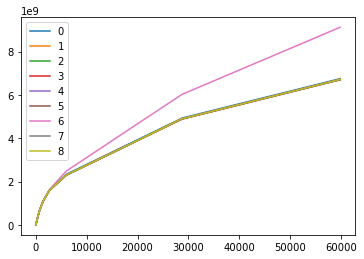

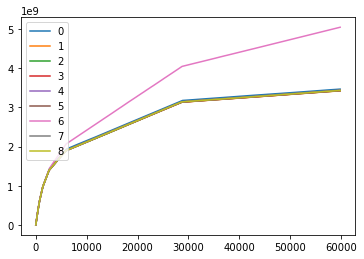

In [13]:
for i in range(dummy):
    data_delta = np.cumsum( regrets_bmoz[i] )
    data = np.cumsum(regrets_bmoz[i])
    plt.plot( data_delta, label='{}'.format(i) ) 
plt.legend()
plt.show()

for i in range(dummy):
    data_delta = np.cumsum( delta_regrets_bmoz[i] )
    data = np.cumsum(regrets_bmoz[i])
    plt.plot( data_delta, label='{}'.format(i) ) 
plt.legend()
plt.show()

In [14]:
regret_m = np.mean(np.cumsum(regrets_bmoz, axis=1), axis=0)
regret_std = np.std(np.cumsum(regrets_bmoz, axis=1), axis=0)
regret_m_delta = np.mean(np.cumsum(delta_regrets_bmoz, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(delta_regrets_bmoz, axis=1), axis=0)

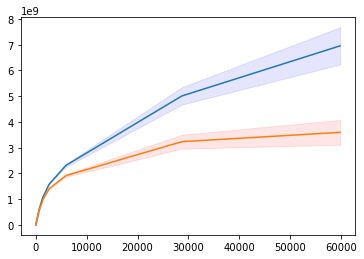

In [15]:
plt.plot(regret_m)
plt.plot(regret_m_delta)
plt.fill_between(np.array(range(len(regret_m))), 
                 regret_m - regret_std, regret_m + regret_std, alpha=0.1, color='b')
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [16]:
np.savetxt('bmoz_delta.csv', delta_regrets_bmoz)
np.savetxt('bmoz.csv', regrets_bmoz)